# TESTING MODELS

Let us try a few classification models
## Classical ML models

In [1]:
import pandas as pd
import time
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, multilabel_confusion_matrix, accuracy_score, classification_report, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
models = []

In [3]:
df = pd.read_csv('data/cleaned_train.csv')
df.shape, df.columns

((76518, 38),
 Index(['id', 'marital_status', 'appln_mode', 'appln_order', 'prog_of_study',
        'morn/eve_attend', 'prev_edu', 'prev_edu_grade', 'nationality',
        'mom_edu', 'dad_edu', 'mom_occup', 'dad_occup', 'admission_grade',
        'was_displaced', 'edu_spl_need', 'has_student_debt', 'no_fee_dues',
        'gender', 'got_scholarship', 'age_at_start', 'is_international_student',
        'sem1_units_credited', 'sem1_units_enrolled', 'sem1_units_eval',
        'sem1_units_approved', 'sem1_units_grade', 'sem1_units_no_eval',
        'sem2_units_credited', 'sem2_units_enrolled', 'sem2_units_eval',
        'sem2_units_approved', 'sem2_units_grade', 'sem2_units_no_eval',
        'unemployment_rate', 'inflation', 'gdp', 'Target'],
       dtype='object'))

In [4]:
X,y = df.drop(columns=['id','Target']).values, df['Target'].values

(Target
 Graduate    36282
 Dropout     25296
 Enrolled    14940
 Name: count, dtype: int64,
 <Axes: >)

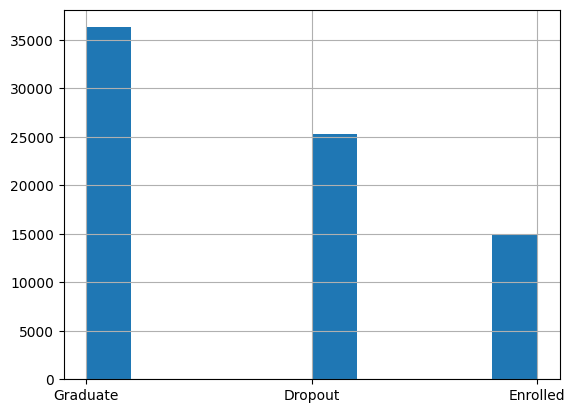

In [5]:
df['Target'].value_counts(), df['Target'].hist()

So we have an imbalanced dataset. To handle this - for classical ML models, we oversample the smaller classes

In [6]:
# Train test split
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_l = le.fit(y)
y_enc = y_l.transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size=0.2, random_state=42)

### Decision tree

First we check the performance without any oversampling

In [7]:
from sklearn import tree

In [8]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train,y_train)
end = time.perf_counter()

CPU times: total: 250 ms
Wall time: 1.08 s


In [9]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9139,  1137],
        [ 1024,  4004]],

       [[10690,  1597],
        [ 1577,  1440]],

       [[ 6804,  1241],
        [ 1374,  5885]]], dtype=int64)

In [10]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.6947845164786554, 0.7402639832723471)

In [11]:
print('DECISION TREE - NO PREPROCESSING')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_no_preprocessing', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - NO PREPROCESSING


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.7788368021785644, 'recal...",1.072654


Next, let us use `SMOTE` (Synthetic Minority Over-sampling Technique) to oversample the minority classes

In [12]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [13]:
#Apply Over Sampling
print(f'Before Oversampling {sorted(Counter(y_train).items())}')
X_train1, y_train1 = SMOTE().fit_resample(X_train, y_train)
print(f'After Oversampling {sorted(Counter(y_train1).items())}')

Before Oversampling [(0, 20268), (1, 11923), (2, 29023)]
After Oversampling [(0, 29023), (1, 29023), (2, 29023)]


In [14]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 1.7 s
Wall time: 6.15 s


In [15]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9187,  1089],
        [ 1027,  4001]],

       [[10681,  1606],
        [ 1502,  1515]],

       [[ 6863,  1182],
        [ 1348,  5911]]], dtype=int64)

In [16]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7040659276285002, 0.7466675378985886)

In [17]:
print('DECISION TREE - SMOTE')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_oversampling', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - SMOTE


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.7788368021785644, 'recal...",1.072654
1,Decision_tree_oversampling,"{'0': {'precision': 0.7860510805500982, 'recal...",6.156376


Let us try an undersampler

In [18]:
from imblearn.under_sampling import RandomUnderSampler

In [19]:
#Apply Random Under Sampling
rus = RandomUnderSampler(random_state=0)
print(f'Before Undersampling {sorted(Counter(y_train).items())}')
X_train1, y_train1 =rus.fit_resample(X_train, y_train)
print(f'After Undersampling {sorted(Counter(y_train1).items())}')

Before Undersampling [(0, 20268), (1, 11923), (2, 29023)]
After Undersampling [(0, 11923), (1, 11923), (2, 11923)]


In [20]:
%%time
model_dt = tree.DecisionTreeClassifier()
start = time.perf_counter()
model_dt.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 750 ms
Wall time: 1.56 s


In [21]:
y_pred = model_dt.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[9230, 1046],
        [1165, 3863]],

       [[9866, 2421],
        [1203, 1814]],

       [[7135,  910],
        [2009, 5250]]], dtype=int64)

In [22]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.6975990596209515, 0.7139963408259279)

In [23]:
print('DECISION TREE - Random Undersampler')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Decision_tree_undersampling', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

DECISION TREE - Random Undersampler


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.7788368021785644, 'recal...",1.072654
1,Decision_tree_oversampling,"{'0': {'precision': 0.7860510805500982, 'recal...",6.156376
2,Decision_tree_undersampling,"{'0': {'precision': 0.7869219800366674, 'recal...",1.553906


So, the performance is not vastly affected by the oversampling or undersampling => Decision tree is robust to imbalanced data

### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train,y_train)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 1.880500299972482s, accuracy: 0.7921458442237324
n_estimators: 10, time_taken: 4.305032300006133s, accuracy: 0.8080240460010455
n_estimators: 20, time_taken: 7.905312299961224s, accuracy: 0.8173680083638265
n_estimators: 50, time_taken: 11.448170099989511s, accuracy: 0.8253397804495557
n_estimators: 100, time_taken: 19.88295959995594s, accuracy: 0.829064296915839
n_estimators: 200, time_taken: 32.86680700001307s, accuracy: 0.8289989545216937
n_estimators: 300, time_taken: 103.13362519996008s, accuracy: 0.8285415577626765


In [26]:
model.feature_importances_

array([0.00261352, 0.01614678, 0.01182737, 0.0227489 , 0.00187919,
       0.00389177, 0.03333774, 0.00065024, 0.01733171, 0.01729405,
       0.01926365, 0.02374468, 0.04071813, 0.00697674, 0.00065148,
       0.00704927, 0.03136767, 0.01033145, 0.01962777, 0.03166889,
       0.00049027, 0.00275186, 0.01041268, 0.04227826, 0.11143002,
       0.09587525, 0.00229438, 0.00202832, 0.01309029, 0.04971184,
       0.1816168 , 0.11436349, 0.00255971, 0.01786807, 0.01626294,
       0.01784479])

In [27]:
y_pred = model.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_no_preprocessing', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.7788368021785644, 'recal...",1.072654
1,Decision_tree_oversampling,"{'0': {'precision': 0.7860510805500982, 'recal...",6.156376
2,Decision_tree_undersampling,"{'0': {'precision': 0.7869219800366674, 'recal...",1.553906
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.902131361461505, 'recall...",103.133625


Text(0.5, 1.0, 'Training time')

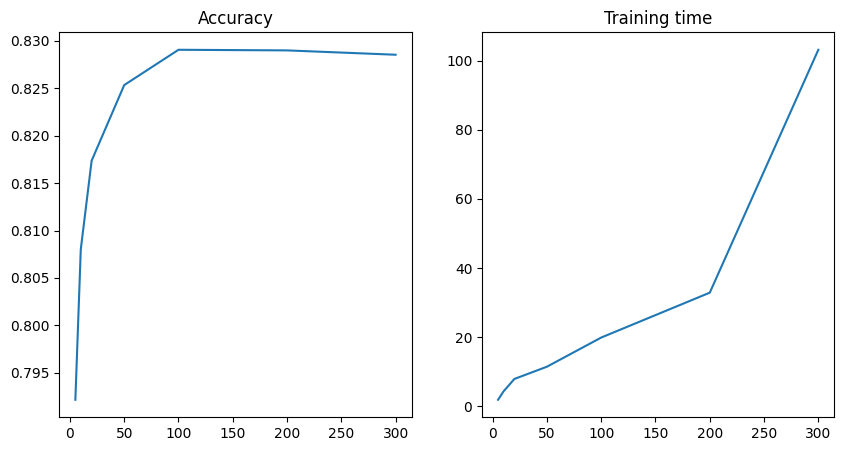

In [28]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')

Try with SMOTE

In [29]:
X_train1, y_train1 = SMOTE().fit_resample(X_train,y_train)
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 6.136870199989062s, accuracy: 0.7922111866178777
n_estimators: 10, time_taken: 11.771326199988835s, accuracy: 0.8102456874019864
n_estimators: 20, time_taken: 22.206744999974035s, accuracy: 0.8194589649764767
n_estimators: 50, time_taken: 61.13696009997511s, accuracy: 0.8254704652378463
n_estimators: 100, time_taken: 108.4488246999681s, accuracy: 0.8274960794563513
n_estimators: 200, time_taken: 219.9635470000212s, accuracy: 0.8278227914270779
n_estimators: 300, time_taken: 316.3382472000085s, accuracy: 0.8262545739675902


In [30]:
model.feature_importances_

array([0.00278641, 0.01322363, 0.01131421, 0.01856088, 0.00162874,
       0.00368339, 0.02735897, 0.00059285, 0.01533571, 0.01492784,
       0.01791813, 0.02179159, 0.03174534, 0.00894498, 0.00079443,
       0.00926347, 0.03822867, 0.01726556, 0.03580048, 0.02842272,
       0.00048648, 0.00275481, 0.01380957, 0.05094282, 0.1181322 ,
       0.07186738, 0.00234549, 0.00217779, 0.01461049, 0.05968798,
       0.17983013, 0.11075862, 0.00253318, 0.01722765, 0.01580187,
       0.01744553])

In [31]:
y_pred = model.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_oversampling', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.7788368021785644, 'recal...",1.072654
1,Decision_tree_oversampling,"{'0': {'precision': 0.7860510805500982, 'recal...",6.156376
2,Decision_tree_undersampling,"{'0': {'precision': 0.7869219800366674, 'recal...",1.553906
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.902131361461505, 'recall...",103.133625
4,RandomForest_oversampling,"{'0': {'precision': 0.9071915548713437, 'recal...",316.338247


Text(0.5, 1.0, 'Training time')

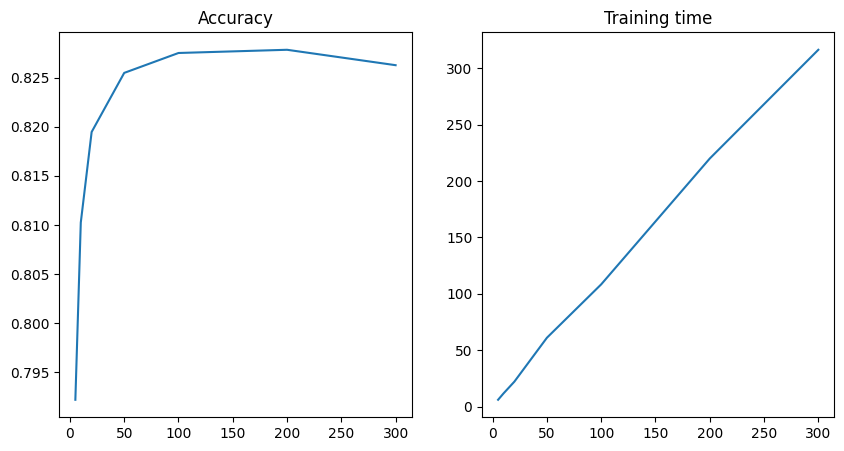

In [32]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')


Let's try Undersampling

In [33]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)
estims = [5,10,20,50,100,200,300]
model = RandomForestClassifier()
acc,tim = [], []
for x in estims:
    model = RandomForestClassifier(n_estimators=x,warm_start=True)
    start = time.perf_counter()
    model.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_estimators: {x}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_estimators: 5, time_taken: 1.215120200009551s, accuracy: 0.7726738107684266
n_estimators: 10, time_taken: 2.4869209000025876s, accuracy: 0.7862650287506534
n_estimators: 20, time_taken: 5.6522107000346296s, accuracy: 0.7988107684265552
n_estimators: 50, time_taken: 13.600283700041473s, accuracy: 0.8065211709357031
n_estimators: 100, time_taken: 14.293012399983127s, accuracy: 0.8100496602195505
n_estimators: 200, time_taken: 49.51520409999648s, accuracy: 0.8077626764244642
n_estimators: 300, time_taken: 74.57709800003795s, accuracy: 0.8085467851542081


In [34]:
model.feature_importances_

array([0.00296302, 0.01743689, 0.01295436, 0.02484843, 0.00223617,
       0.00458966, 0.03634419, 0.00073488, 0.01907915, 0.01890366,
       0.02150847, 0.02643342, 0.04386891, 0.007576  , 0.00068839,
       0.00741115, 0.03095305, 0.00909464, 0.01995946, 0.03183902,
       0.00060155, 0.00305927, 0.01202311, 0.05142871, 0.08994126,
       0.08863221, 0.00255271, 0.00227369, 0.01436506, 0.05813241,
       0.15243657, 0.12404515, 0.00280323, 0.01977396, 0.01814238,
       0.0203658 ])

In [35]:
y_pred = model.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'RandomForest_undersampling', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.7788368021785644, 'recal...",1.072654
1,Decision_tree_oversampling,"{'0': {'precision': 0.7860510805500982, 'recal...",6.156376
2,Decision_tree_undersampling,"{'0': {'precision': 0.7869219800366674, 'recal...",1.553906
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.902131361461505, 'recall...",103.133625
4,RandomForest_oversampling,"{'0': {'precision': 0.9071915548713437, 'recal...",316.338247
5,RandomForest_undersampling,"{'0': {'precision': 0.9196222938737909, 'recal...",74.577098


Text(0.5, 1.0, 'Training time')

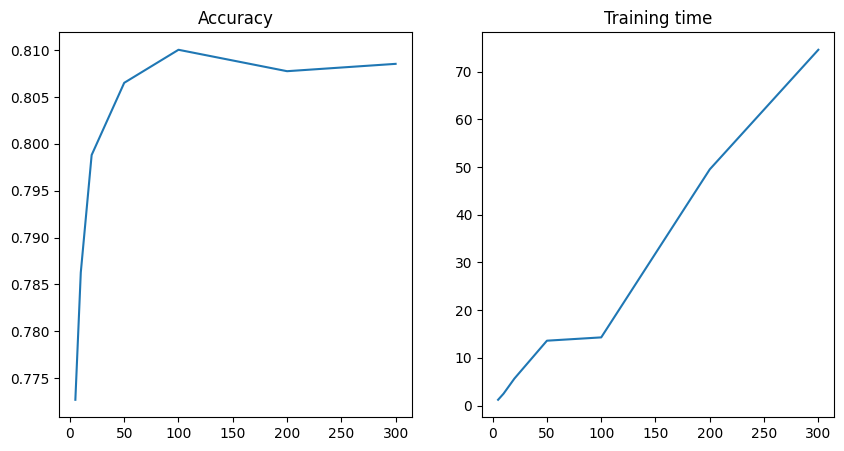

In [36]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(estims,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(estims,tim)
ax2.set_title('Training time')


### Naive Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB

In [38]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train, y_train)
end = time.perf_counter()

CPU times: total: 15.6 ms
Wall time: 156 ms


In [39]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9641,   635],
        [ 1027,  4001]],

       [[11091,  1196],
        [ 1689,  1328]],

       [[ 6313,  1732],
        [  847,  6412]]], dtype=int64)

In [40]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7064111508343623, 0.7671850496602195)

In [41]:
print('NAIVE BAYES - No preprocessing')
x = classification_report(y_val, y_pred, labels = sorted(list(set(y_enc))), digits=4, output_dict=True)
models.append({'model':'Naive_Bayes_no_preprocessing', 'metrics': x, 'training_time(s)':(end-start)})
pd.DataFrame(models)

NAIVE BAYES - No preprocessing


,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.7788368021785644, 'recal...",1.072654
1,Decision_tree_oversampling,"{'0': {'precision': 0.7860510805500982, 'recal...",6.156376
2,Decision_tree_undersampling,"{'0': {'precision': 0.7869219800366674, 'recal...",1.553906
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.902131361461505, 'recall...",103.133625
4,RandomForest_oversampling,"{'0': {'precision': 0.9071915548713437, 'recal...",316.338247
5,RandomForest_undersampling,"{'0': {'precision': 0.9196222938737909, 'recal...",74.577098
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8630284728213977, 'recal...",0.153431


Let's try oversampling 

In [42]:
X_train1, y_train1 = SMOTE().fit_resample(X_train, y_train)

In [43]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 109 ms
Wall time: 162 ms


In [44]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9601,   675],
        [ 1014,  4014]],

       [[10646,  1641],
        [ 1240,  1777]],

       [[ 6895,  1150],
        [ 1212,  6047]]], dtype=int64)

In [45]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7401199666593422, 0.7735232618923157)

In [46]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'Naive_Bayes_oversampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.7788368021785644, 'recal...",1.072654
1,Decision_tree_oversampling,"{'0': {'precision': 0.7860510805500982, 'recal...",6.156376
2,Decision_tree_undersampling,"{'0': {'precision': 0.7869219800366674, 'recal...",1.553906
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.902131361461505, 'recall...",103.133625
4,RandomForest_oversampling,"{'0': {'precision': 0.9071915548713437, 'recal...",316.338247
5,RandomForest_undersampling,"{'0': {'precision': 0.9196222938737909, 'recal...",74.577098
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8630284728213977, 'recal...",0.153431
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8560460652591171, 'recal...",0.164299


Let's try undersampling

In [47]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train, y_train)

In [48]:
%%time
model_nb = GaussianNB()
start = time.perf_counter()
model_nb.fit(X_train1,y_train1)
end = time.perf_counter()

CPU times: total: 62.5 ms
Wall time: 72.7 ms


In [49]:
y_pred = model_nb.predict(X_val)
mat = multilabel_confusion_matrix(y_val,y_pred)
mat

array([[[ 9657,   619],
        [ 1039,  3989]],

       [[10877,  1410],
        [ 1502,  1515]],

       [[ 6538,  1507],
        [  995,  6264]]], dtype=int64)

In [50]:
balanced_accuracy_score(y_val,y_pred), accuracy_score(y_val,y_pred)

(0.7194801452737726, 0.7689492943021432)

In [51]:
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'Naive_Bayes_undersampling', 'metrics': x, 'training_time(s)': (end-start)})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.7788368021785644, 'recal...",1.072654
1,Decision_tree_oversampling,"{'0': {'precision': 0.7860510805500982, 'recal...",6.156376
2,Decision_tree_undersampling,"{'0': {'precision': 0.7869219800366674, 'recal...",1.553906
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.902131361461505, 'recall...",103.133625
4,RandomForest_oversampling,"{'0': {'precision': 0.9071915548713437, 'recal...",316.338247
5,RandomForest_undersampling,"{'0': {'precision': 0.9196222938737909, 'recal...",74.577098
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8630284728213977, 'recal...",0.153431
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8560460652591171, 'recal...",0.164299
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8656684027777778, 'recal...",0.071734


### K Nearest Neighbors

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train,y_train)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.017732599982991815s, accuracy: 0.7211840041819132
n_neighbors: 5, time_taken: 0.012191499990876764s, accuracy: 0.7356246732880293
n_neighbors: 10, time_taken: 0.012228599982336164s, accuracy: 0.742093570308416
n_neighbors: 15, time_taken: 0.012035599967930466s, accuracy: 0.7419628855201255
n_neighbors: 20, time_taken: 0.012849000049754977s, accuracy: 0.7394798745426032
n_neighbors: 25, time_taken: 0.011871900002006441s, accuracy: 0.7405906952430737
n_neighbors: 50, time_taken: 0.012135399971157312s, accuracy: 0.7292211186617877
n_neighbors: 100, time_taken: 0.012494999973569065s, accuracy: 0.7196811291165708
n_neighbors: 200, time_taken: 0.016947800002526492s, accuracy: 0.7051751176163095
n_neighbors: 400, time_taken: 0.012558899994473904s, accuracy: 0.6838734971249346
n_neighbors: 800, time_taken: 0.015181499999016523s, accuracy: 0.6539466806063774


In [54]:
y_pred = model_knn.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_no_preprocessing', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.7788368021785644, 'recal...",1.072654
1,Decision_tree_oversampling,"{'0': {'precision': 0.7860510805500982, 'recal...",6.156376
2,Decision_tree_undersampling,"{'0': {'precision': 0.7869219800366674, 'recal...",1.553906
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.902131361461505, 'recall...",103.133625
4,RandomForest_oversampling,"{'0': {'precision': 0.9071915548713437, 'recal...",316.338247
5,RandomForest_undersampling,"{'0': {'precision': 0.9196222938737909, 'recal...",74.577098
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8630284728213977, 'recal...",0.153431
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8560460652591171, 'recal...",0.164299
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8656684027777778, 'recal...",0.071734
9,KNN_no_preprocessing,"{'0': {'precision': 0.7102606245597558, 'recal...",0.015181


Text(0.5, 1.0, 'Training time')

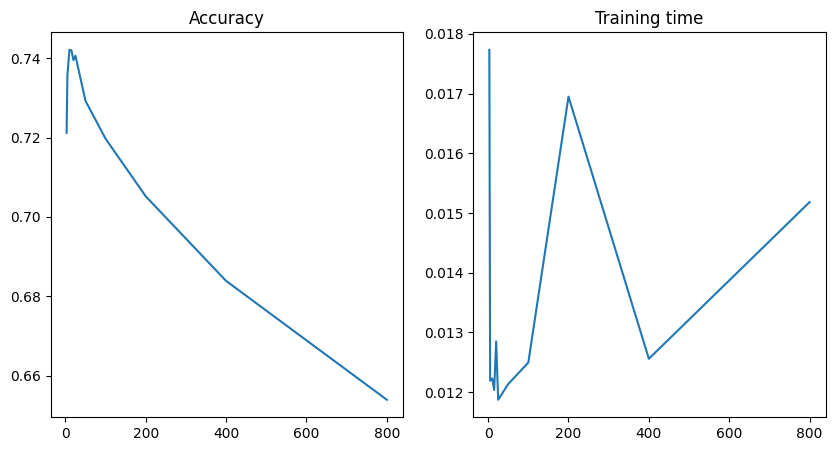

In [55]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

Let's try oversampling

In [56]:
X_train1, y_train1 = SMOTE().fit_resample(X_train,y_train)

In [57]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.018376999942120165s, accuracy: 0.6844615786722426
n_neighbors: 5, time_taken: 0.01588269998319447s, accuracy: 0.685768426555149
n_neighbors: 10, time_taken: 0.016949900018516928s, accuracy: 0.6923680083638265
n_neighbors: 15, time_taken: 0.01544869999634102s, accuracy: 0.6955697856769472
n_neighbors: 20, time_taken: 0.016016900015529245s, accuracy: 0.6923680083638265
n_neighbors: 25, time_taken: 0.018019000010099262s, accuracy: 0.6934788290642969
n_neighbors: 50, time_taken: 0.014588900026865304s, accuracy: 0.6873366440146367
n_neighbors: 100, time_taken: 0.013451899983920157s, accuracy: 0.678058024046001
n_neighbors: 200, time_taken: 0.015465400007087737s, accuracy: 0.6696941975953999
n_neighbors: 400, time_taken: 0.01783089997479692s, accuracy: 0.6583899634082593
n_neighbors: 800, time_taken: 0.019687900028657168s, accuracy: 0.6338212232096184


`n_neighbors=15` gave best accuracy

In [58]:
model_knn = KNeighborsClassifier(n_neighbors=15)
start = time.perf_counter()
model_knn.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model_knn.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_oversampling', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.7788368021785644, 'recal...",1.072654
1,Decision_tree_oversampling,"{'0': {'precision': 0.7860510805500982, 'recal...",6.156376
2,Decision_tree_undersampling,"{'0': {'precision': 0.7869219800366674, 'recal...",1.553906
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.902131361461505, 'recall...",103.133625
4,RandomForest_oversampling,"{'0': {'precision': 0.9071915548713437, 'recal...",316.338247
5,RandomForest_undersampling,"{'0': {'precision': 0.9196222938737909, 'recal...",74.577098
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8630284728213977, 'recal...",0.153431
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8560460652591171, 'recal...",0.164299
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8656684027777778, 'recal...",0.071734
9,KNN_no_preprocessing,"{'0': {'precision': 0.7102606245597558, 'recal...",0.015181


Text(0.5, 1.0, 'Training time')

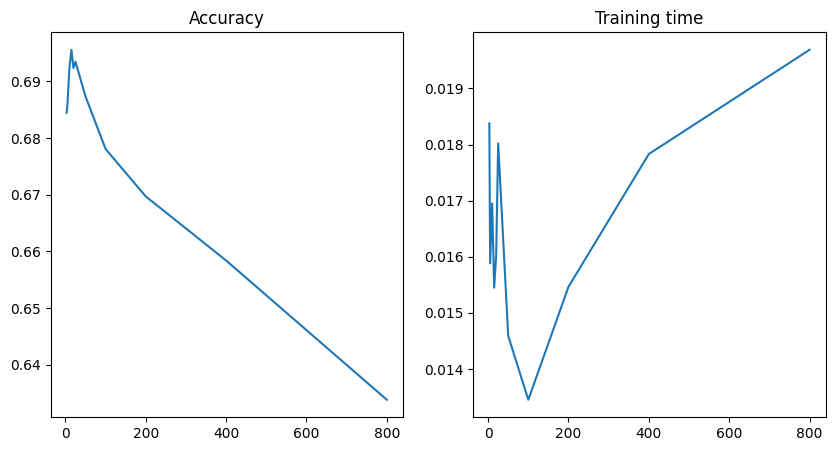

In [59]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

Let's try undersampling

In [60]:
X_train1, y_train1 = RandomUnderSampler().fit_resample(X_train,y_train)

In [61]:
nbors = [3,5,10,15,20,25,50,100,200,400,800]
tim, acc = [], []
model_knn = KNeighborsClassifier()

for n in nbors:
    model_knn = KNeighborsClassifier(n_neighbors=n)
    start = time.perf_counter()
    model_knn.fit(X_train1,y_train1)
    end = time.perf_counter()
    y_pred = model_knn.predict(X_val)
    _acc = accuracy_score(y_val,y_pred)
    tim.append(end-start)
    print(f'n_neighbors: {n}, time_taken: {end-start}s, accuracy: {_acc}')
    acc.append(_acc)

n_neighbors: 3, time_taken: 0.010726000007707626s, accuracy: 0.6779273392577104
n_neighbors: 5, time_taken: 0.007452699996065348s, accuracy: 0.6928254051228437
n_neighbors: 10, time_taken: 0.009854699950665236s, accuracy: 0.6952430737062206
n_neighbors: 15, time_taken: 0.005471099982969463s, accuracy: 0.6955044432828019
n_neighbors: 20, time_taken: 0.006335599988233298s, accuracy: 0.6904730789336121
n_neighbors: 25, time_taken: 0.006000299996230751s, accuracy: 0.6881860951385259
n_neighbors: 50, time_taken: 0.007325699960347265s, accuracy: 0.6776659696811291
n_neighbors: 100, time_taken: 0.0058858999982476234s, accuracy: 0.6690407736539467
n_neighbors: 200, time_taken: 0.007698600005824119s, accuracy: 0.6535546262415055
n_neighbors: 400, time_taken: 0.00626999995438382s, accuracy: 0.6276136957658128
n_neighbors: 800, time_taken: 0.007833499985281378s, accuracy: 0.5897151071615264


`n_neighbors=15` gave best accuracy

In [62]:
model_knn = KNeighborsClassifier(n_neighbors=15)
start = time.perf_counter()
model_knn.fit(X_train1,y_train1)
end = time.perf_counter()
y_pred = model_knn.predict(X_val)
x = classification_report(y_val, y_pred, digits=4, labels=sorted(list(set(y_enc))), output_dict=True)
models.append({'model': 'KNN_undersampling', 'metrics': x, 'training_time(s)': tim[-1]})
pd.DataFrame(models)

,model,metrics,training_time(s)
0,Decision_tree_no_preprocessing,"{'0': {'precision': 0.7788368021785644, 'recal...",1.072654
1,Decision_tree_oversampling,"{'0': {'precision': 0.7860510805500982, 'recal...",6.156376
2,Decision_tree_undersampling,"{'0': {'precision': 0.7869219800366674, 'recal...",1.553906
3,RandomForest_no_preprocessing,"{'0': {'precision': 0.902131361461505, 'recall...",103.133625
4,RandomForest_oversampling,"{'0': {'precision': 0.9071915548713437, 'recal...",316.338247
5,RandomForest_undersampling,"{'0': {'precision': 0.9196222938737909, 'recal...",74.577098
6,Naive_Bayes_no_preprocessing,"{'0': {'precision': 0.8630284728213977, 'recal...",0.153431
7,Naive_Bayes_oversampling,"{'0': {'precision': 0.8560460652591171, 'recal...",0.164299
8,Naive_Bayes_undersampling,"{'0': {'precision': 0.8656684027777778, 'recal...",0.071734
9,KNN_no_preprocessing,"{'0': {'precision': 0.7102606245597558, 'recal...",0.015181


Text(0.5, 1.0, 'Training time')

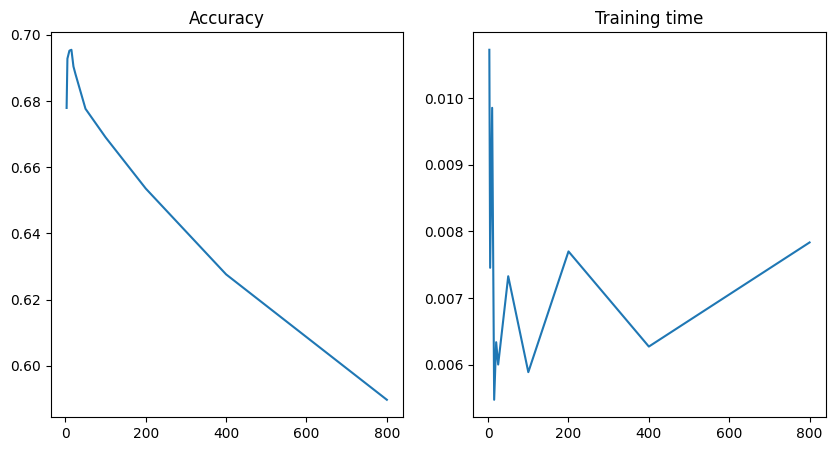

In [63]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(nbors,acc)
ax1.set_title('Accuracy')

ax2 = fig.add_subplot(122)
ax2.plot(nbors,tim)
ax2.set_title('Training time')

In [76]:
df_results = pd.DataFrame(models)

In [81]:
df_results['precision'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['precision'],3), 1: round(x['1']['precision'],3), 2: round(x['2']['precision'],3)})
df_results['recall'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['recall'],3), 1: round(x['1']['recall'],3), 2: round(x['2']['recall'],3)})
df_results['f1-score'] = df_results['metrics'].apply(lambda x: {0: round(x['0']['f1-score'],3), 1: round(x['1']['f1-score'],3), 2: round(x['2']['f1-score'],3)})
df_results['macro_avg'] = df_results['metrics'].apply(lambda x: {k: round(x['macro avg'][k],3) for k in x['macro avg'].keys()})
df_results['weighted_avg'] = df_results['metrics'].apply(lambda x: {k: round(x['weighted avg'][k],3) for k in x['weighted avg'].keys()})
df_results['accuracy'] = df_results['metrics'].apply(lambda x: round(x['accuracy'],3))
df_results['time (s)'] = df_results['training_time(s)']
df_results.drop(columns=['metrics','training_time(s)'],inplace=True)

In [83]:
df_results.to_csv('data/benchmarking.csv',index=False)
df_results

,model,precision,recall,f1-score,macro_avg,weighted_avg,accuracy,time (s)
0,Decision_tree_no_preprocessing,"{0: 0.779, 1: 0.474, 2: 0.826}","{0: 0.796, 1: 0.477, 2: 0.811}","{0: 0.787, 1: 0.476, 2: 0.818}","{'precision': 0.693, 'recall': 0.695, 'f1-score': 0.694, 'support': 15304.0}","{'precision': 0.741, 'recall': 0.74, 'f1-score': 0.741, 'support': 15304.0}",0.740,1.072654
1,Decision_tree_oversampling,"{0: 0.786, 1: 0.485, 2: 0.833}","{0: 0.796, 1: 0.502, 2: 0.814}","{0: 0.791, 1: 0.494, 2: 0.824}","{'precision': 0.702, 'recall': 0.704, 'f1-score': 0.703, 'support': 15304.0}","{'precision': 0.749, 'recall': 0.747, 'f1-score': 0.748, 'support': 15304.0}",0.747,6.156376
2,Decision_tree_undersampling,"{0: 0.787, 1: 0.428, 2: 0.852}","{0: 0.768, 1: 0.601, 2: 0.723}","{0: 0.777, 1: 0.5, 2: 0.782}","{'precision': 0.689, 'recall': 0.698, 'f1-score': 0.687, 'support': 15304.0}","{'precision': 0.747, 'recall': 0.714, 'f1-score': 0.725, 'support': 15304.0}",0.714,1.553906
3,RandomForest_no_preprocessing,"{0: 0.902, 1: 0.647, 2: 0.85}","{0: 0.825, 1: 0.604, 2: 0.925}","{0: 0.862, 1: 0.625, 2: 0.886}","{'precision': 0.8, 'recall': 0.784, 'f1-score': 0.791, 'support': 15304.0}","{'precision': 0.827, 'recall': 0.829, 'f1-score': 0.826, 'support': 15304.0}",0.829,103.133625
4,RandomForest_oversampling,"{0: 0.907, 1: 0.628, 2: 0.855}","{0: 0.82, 1: 0.623, 2: 0.915}","{0: 0.862, 1: 0.626, 2: 0.884}","{'precision': 0.797, 'recall': 0.786, 'f1-score': 0.79, 'support': 15304.0}","{'precision': 0.828, 'recall': 0.826, 'f1-score': 0.826, 'support': 15304.0}",0.826,316.338247
5,RandomForest_undersampling,"{0: 0.92, 1: 0.552, 2: 0.895}","{0: 0.794, 1: 0.763, 2: 0.838}","{0: 0.852, 1: 0.641, 2: 0.865}","{'precision': 0.789, 'recall': 0.798, 'f1-score': 0.786, 'support': 15304.0}","{'precision': 0.835, 'recall': 0.809, 'f1-score': 0.817, 'support': 15304.0}",0.809,74.577098
6,Naive_Bayes_no_preprocessing,"{0: 0.863, 1: 0.526, 2: 0.787}","{0: 0.796, 1: 0.44, 2: 0.883}","{0: 0.828, 1: 0.479, 2: 0.833}","{'precision': 0.726, 'recall': 0.706, 'f1-score': 0.713, 'support': 15304.0}","{'precision': 0.761, 'recall': 0.767, 'f1-score': 0.761, 'support': 15304.0}",0.767,0.153431
7,Naive_Bayes_oversampling,"{0: 0.856, 1: 0.52, 2: 0.84}","{0: 0.798, 1: 0.589, 2: 0.833}","{0: 0.826, 1: 0.552, 2: 0.837}","{'precision': 0.739, 'recall': 0.74, 'f1-score': 0.738, 'support': 15304.0}","{'precision': 0.782, 'recall': 0.774, 'f1-score': 0.777, 'support': 15304.0}",0.774,0.164299
8,Naive_Bayes_undersampling,"{0: 0.866, 1: 0.518, 2: 0.806}","{0: 0.793, 1: 0.502, 2: 0.863}","{0: 0.828, 1: 0.51, 2: 0.834}","{'precision': 0.73, 'recall': 0.719, 'f1-score': 0.724, 'support': 15304.0}","{'precision': 0.769, 'recall': 0.769, 'f1-score': 0.768, 'support': 15304.0}",0.769,0.071734
9,KNN_no_preprocessing,"{0: 0.71, 1: 0.48, 2: 0.661}","{0: 0.602, 1: 0.282, 2: 0.845}","{0: 0.651, 1: 0.355, 2: 0.742}","{'precision': 0.617, 'recall': 0.576, 'f1-score': 0.583, 'support': 15304.0}","{'precision': 0.642, 'recall': 0.654, 'f1-score': 0.636, 'support': 15304.0}",0.654,0.015181
